import statement

In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt 
import collections 
import os
import time
import json
import random
import numpy as np 

from PIL import  Image

In [2]:
devices = tf.config.experimental.list_physical_devices("CPU")
print(devices)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


getting data ready

In [3]:
data_dir = r'flickr8k'
image_dir = f'{data_dir}\Images'
txt_file = f'{data_dir}\captions.txt'

In [4]:
full_image_dir = []
s0_comment_s1 = []

with open(txt_file,'r') as file:
  content = file.readlines()
  content = content[1:]
  for line in content:
    result = line.split(',')
    image_name = result[0]
    raw_comment = result[1]
    single_image_full_dir = f'{image_dir}\{image_name}'
    
    single_comment = f'<start> {raw_comment} <end>'
    single_comment = single_comment.replace("\n","").replace(".","")
    # D:\test_locally_notebooks\show_and_tell_code\flickr8k\Images\667626_18933d713e.jpg
       
    # single_comment = raw_comment
    full_image_dir.append(single_image_full_dir)
    s0_comment_s1.append(single_comment)

cutting the datatset

In [5]:
full_image_dir = full_image_dir[:1500]
s0_comment_s1 = s0_comment_s1[:1500]

In [6]:
len(full_image_dir)

1500

In [7]:
len(s0_comment_s1)

1500

In [8]:
full_image_dir[:10]

['flickr8k\\Images\\1000268201_693b08cb0e.jpg',
 'flickr8k\\Images\\1000268201_693b08cb0e.jpg',
 'flickr8k\\Images\\1000268201_693b08cb0e.jpg',
 'flickr8k\\Images\\1000268201_693b08cb0e.jpg',
 'flickr8k\\Images\\1000268201_693b08cb0e.jpg',
 'flickr8k\\Images\\1001773457_577c3a7d70.jpg',
 'flickr8k\\Images\\1001773457_577c3a7d70.jpg',
 'flickr8k\\Images\\1001773457_577c3a7d70.jpg',
 'flickr8k\\Images\\1001773457_577c3a7d70.jpg',
 'flickr8k\\Images\\1001773457_577c3a7d70.jpg']

In [9]:
s0_comment_s1[:10]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> A girl going into a wooden building  <end>',
 '<start> A little girl climbing into a wooden playhouse  <end>',
 '<start> A little girl climbing the stairs to her playhouse  <end>',
 '<start> A little girl in a pink dress going into a wooden cabin  <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road  <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street  <end>',
 '<start> Two dogs of different breeds looking at each other on the road  <end>',
 '<start> Two dogs on pavement moving toward each other  <end>']

Mapping each image to their 5 captions through dict

In [10]:
image_path_to_caption = collections.defaultdict(list)
data_pair = len(full_image_dir)
for i in range(data_pair):
    image_path_to_caption[full_image_dir[i]].append(s0_comment_s1[i])


In [11]:
image_path_to_caption[full_image_dir[100]]

['<start> Two different breeds of brown and white dogs play on the beach  <end>',
 '<start> Two dogs are making a turn on a soft sand beach  <end>',
 '<start> Two dogs playing in the sand at the beach  <end>',
 '<start> Two dogs playing together on a beach  <end>',
 '<start> Two large tan dogs play along a sandy beach  <end>']

In [12]:
print(f'Total images are {len(image_path_to_caption)}')

Total images are 300


Preparing the data for training

In [13]:
train_image_paths = list(image_path_to_caption.keys())
random.shuffle(train_image_paths)
print(len(train_image_paths))


300


In [14]:
train_captions = []
image_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    image_name_vector.extend([image_path] * len(caption_list))

In [15]:
train_captions[5:10]

['<start> A black and brown dog is laying on a white shaggy carpet  <end>',
 '<start> A brown and black dog is laying on a shaggy rug  <end>',
 '<start> a small brown and black dog lying down in a furry rug  <end>',
 '<start> A small dog is sitting on white carpet  <end>',
 '<start> A small dog shakes its head on a white shag carpet  <end>']

In [16]:
image_name_vector[5:10]

['flickr8k\\Images\\1244140539_da4804d828.jpg',
 'flickr8k\\Images\\1244140539_da4804d828.jpg',
 'flickr8k\\Images\\1244140539_da4804d828.jpg',
 'flickr8k\\Images\\1244140539_da4804d828.jpg',
 'flickr8k\\Images\\1244140539_da4804d828.jpg']

In [17]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,(299,299))
    image= tf.keras.applications.inception_v3.preprocess_input(image)
    return image,image_path
    

In [18]:
out = load_image(image_name_vector[0])
print(out)

(<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[-0.13982558, -0.01433533,  0.10331166],
        [-0.13732046, -0.01183027,  0.10581672],
        [-0.1504361 , -0.02494591,  0.0927012 ],
        ...,
        [-0.5140527 , -0.44063193, -0.3650331 ],
        [-0.5135948 , -0.4508497 , -0.3645752 ],
        [-0.3571871 , -0.294442  , -0.20816743]],

       [[-0.15042686, -0.00224668,  0.12447643],
        [-0.13713074,  0.01093554,  0.14677262],
        [-0.12465751,  0.00682008,  0.14715719],
        ...,
        [-0.28425348, -0.20919383, -0.09420252],
        [-0.2776187 , -0.21941155, -0.09683305],
        [-0.22387218, -0.16566509, -0.04308659]],

       [[-0.13637167,  0.0096575 ,  0.14299095],
        [-0.12067002,  0.02522099,  0.16961753],
        [-0.0918749 ,  0.03070176,  0.18214965],
        ...,
        [-0.133973  , -0.05613089,  0.08362746],
        [-0.1174829 , -0.06258094,  0.08410406],
        [-0.1306603 , -0.07575834,  0.07092667]],

       ...,

    

Loading the Inception V3 Model

In [19]:
image_model = tf.keras.applications.InceptionV3(include_top = False,weights = 'imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input,hidden_layer)

In [20]:
print(image_model.layers[-1].output)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 2048), dtype=tf.float32, name=None), name='mixed10/concat:0', description="created by layer 'mixed10'")


Create Dataset Pipeline using tensorflow dataset

In [21]:
encode_train = sorted(set(image_name_vector))
print(encode_train)

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image).batch(32)

['flickr8k\\Images\\1000268201_693b08cb0e.jpg', 'flickr8k\\Images\\1001773457_577c3a7d70.jpg', 'flickr8k\\Images\\1002674143_1b742ab4b8.jpg', 'flickr8k\\Images\\1003163366_44323f5815.jpg', 'flickr8k\\Images\\1007129816_e794419615.jpg', 'flickr8k\\Images\\1007320043_627395c3d8.jpg', 'flickr8k\\Images\\1009434119_febe49276a.jpg', 'flickr8k\\Images\\1012212859_01547e3f17.jpg', 'flickr8k\\Images\\1015118661_980735411b.jpg', 'flickr8k\\Images\\1015584366_dfcec3c85a.jpg', 'flickr8k\\Images\\101654506_8eb26cfb60.jpg', 'flickr8k\\Images\\101669240_b2d3e7f17b.jpg', 'flickr8k\\Images\\1016887272_03199f49c4.jpg', 'flickr8k\\Images\\1019077836_6fc9b15408.jpg', 'flickr8k\\Images\\1019604187_d087bf9a5f.jpg', 'flickr8k\\Images\\1020651753_06077ec457.jpg', 'flickr8k\\Images\\1022454332_6af2c1449a.jpg', 'flickr8k\\Images\\1022454428_b6b660a67b.jpg', 'flickr8k\\Images\\1022975728_75515238d8.jpg', 'flickr8k\\Images\\102351840_323e3de834.jpg', 'flickr8k\\Images\\1024138940_f1fefbdce1.jpg', 'flickr8k\\Imag

In [22]:
print(image_dataset)

#[(tensor,image_path),(tensor,image_path).....]

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [23]:
from tqdm import tqdm
for img,path in tqdm(image_dataset):
    print(img.shape)
    print(path.shape)
    
    batch_features = image_features_extract_model(img)
    # print(batch_features.shape)

    batch_features = tf.reshape(batch_features,(batch_features.shape[0],-1,batch_features.shape[3]))
    print(batch_features.shape)
    
    for bf, p in zip(batch_features,path):
        path_of_features = p.numpy().decode("utf-8")
        np.save(path_of_features,bf.numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

(32, 299, 299, 3)
(32,)


 10%|█         | 1/10 [00:02<00:24,  2.74s/it]

(32, 64, 2048)
(32, 299, 299, 3)
(32,)


 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

(32, 64, 2048)
(32, 299, 299, 3)
(32,)


 30%|███       | 3/10 [00:07<00:17,  2.45s/it]

(32, 64, 2048)
(32, 299, 299, 3)
(32,)


 40%|████      | 4/10 [00:10<00:15,  2.51s/it]

(32, 64, 2048)
(32, 299, 299, 3)
(32,)


 50%|█████     | 5/10 [00:12<00:12,  2.52s/it]

(32, 64, 2048)
(32, 299, 299, 3)
(32,)


 60%|██████    | 6/10 [00:15<00:10,  2.52s/it]

(32, 64, 2048)
(32, 299, 299, 3)
(32,)


 70%|███████   | 7/10 [00:17<00:07,  2.54s/it]

(32, 64, 2048)
(32, 299, 299, 3)
(32,)


 80%|████████  | 8/10 [00:20<00:05,  2.54s/it]

(32, 64, 2048)
(32, 299, 299, 3)
(32,)


 90%|█████████ | 9/10 [00:22<00:02,  2.51s/it]

(32, 64, 2048)
(12, 299, 299, 3)
(12,)


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]

(12, 64, 2048)


In [24]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

captions preprocessing

In [25]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                  oov_token = "<unk>",
                                                  filters = '!#$%&()*+_,-/:;-=?@[\]^_*{|}~')
tokenizer.fit_on_texts(train_captions)


In [26]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
print(tokenizer.word_index['<pad>'])
print(tokenizer.index_word[0])

0
<pad>


In [27]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [28]:
len(train_seqs)

1500

In [29]:
train_seqs[:10]

[[3, 2, 256, 8, 149, 335, 58, 7, 6, 110, 4],
 [3, 15, 101, 22, 257, 21, 859, 29, 110, 234, 256, 7, 2, 53, 118, 105, 4],
 [3, 15, 101, 398, 58, 2, 30, 110, 234, 860, 7, 29, 861, 79, 105, 4],
 [3, 169, 101, 4],
 [3, 15, 25, 48, 94, 2, 30, 256, 295, 7, 2, 198, 399, 4],
 [3, 2, 18, 9, 26, 11, 8, 137, 7, 2, 24, 625, 503, 4],
 [3, 2, 26, 9, 18, 11, 8, 137, 7, 2, 625, 626, 4],
 [3, 2, 46, 26, 9, 18, 11, 336, 43, 5, 2, 504, 626, 4],
 [3, 2, 46, 11, 8, 33, 7, 24, 503, 4],
 [3, 2, 46, 11, 400, 84, 130, 7, 2, 24, 862, 503, 4]]

In [30]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding = "post")

In [31]:
cap_vector[:4]

array([[  3,   2, 256,   8, 149, 335,  58,   7,   6, 110,   4,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,  15, 101,  22, 257,  21, 859,  29, 110, 234, 256,   7,   2,
         53, 118, 105,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,  15, 101, 398,  58,   2,  30, 110, 234, 860,   7,  29, 861,
         79, 105,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3, 169, 101,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [32]:
max_length = calc_max_length(train_seqs)
max_length

35

Dataset Pipeline

In [33]:
len(image_name_vector)

1500

In [34]:
img_to_cap_vector = collections.defaultdict(list)
for img,cap in zip(image_name_vector,cap_vector):
    img_to_cap_vector[img].append(cap)
    

In [35]:
img_to_cap_vector[image_name_vector[8]]

[array([  3,   2,  18,   9,  26,  11,   8, 137,   7,   2,  24, 625, 503,
          4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([  3,   2,  26,   9,  18,  11,   8, 137,   7,   2, 625, 626,   4,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([  3,   2,  46,  26,   9,  18,  11, 336,  43,   5,   2, 504, 626,
          4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([  3,   2,  46,  11,   8,  33,   7,  24, 503,   4,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([  3,   2,  46,  11, 400,  84, 130,   7,   2,  24, 862, 503,   4,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   

dividing the dataset for training and validation dataset

In [36]:
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys) * 0.8)
img_name_train_keys,img_name_val_keys = img_keys[:slice_index],img_keys[slice_index:]

In [37]:
print(len(img_name_train_keys))
print(len(img_name_val_keys))

240
60


In [38]:
img_name_train = []
cap_train = []

for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt]*capt_len)
    cap_train.extend(img_to_cap_vector[imgt])
    

In [39]:
print(img_name_train[:5])
print(cap_train[0])
print(type(cap_train[0]))

['flickr8k\\Images\\1121416483_c7902d0d49.jpg', 'flickr8k\\Images\\1121416483_c7902d0d49.jpg', 'flickr8k\\Images\\1121416483_c7902d0d49.jpg', 'flickr8k\\Images\\1121416483_c7902d0d49.jpg', 'flickr8k\\Images\\1121416483_c7902d0d49.jpg']
[  3   2  38   8  48   7  59 130   4   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
<class 'numpy.ndarray'>


In [40]:
img_name_val , cap_val = [],[]
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv]*capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [41]:
len(img_name_train),len(cap_train),len(img_name_val),len(cap_val)

(1200, 1200, 300, 300)

In [42]:
batch_size = 16
buffer_size =500
embedding_dim = 250
units = 522
vocab_size =  top_k+1
num_steps = len(img_name_train)
features_shape = 2048
attention_features_shape = 16

In [43]:
def map_func(image_name,cap):
    img_tensor = np.load(image_name.decode("utf-8") + ".npy")
    # print(f'loaded image shape is {img_tensor.shape}')
    # shape is 64,2048
    return img_tensor , cap

In [44]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train,cap_train))


In [45]:
dataset = dataset.map(lambda item1, item2:tf.numpy_function(
    map_func,[item1,item2],[tf.float32,tf.int32]
))

In [46]:
dataset = dataset.shuffle(buffer_size).batch(batch_size)

In [47]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

Bahdanau Attention

In [48]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self,units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
        # these above three will calculate alignment scor(e<t,t`>)
    def call(self,features,hidden):
        hidden_with_time_axis = tf.expand_dims(hidden,1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score,axis = 1)
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector,axis = 1)
        return context_vector,attention_weights
    def intuition(self):
        '''
        feature shape is (m,64,2048)
        hidden shape is (m,n_s)
        n_s means number of hidden units in the decoder rnn
        '''
        
        tst_features_shape = (2, 64, 2048)  # batch_size=2, sequence_length=5, feature_dim=10
        tst_hidden_with_time_axis_shape = (2, 1, 15)  # batch_size=2, 1 time step, hidden_dim=15

        # Creating imaginary tensors with shapes
        tst_features = tf.random.normal(tst_features_shape)
        tst_hidden_with_time_axis = tf.random.normal(tst_hidden_with_time_axis_shape)

        # Calculating attention_hidden_layer
        tst_out1 = self.W1(tst_features)
        tst_out2 = self.W2(tst_hidden_with_time_axis)
        tst_attention_hidden_layer = tf.nn.tanh(tst_out1 + tst_out2)
        tst_score = self.V(tst_attention_hidden_layer)
        tst_attention_weights = tf.nn.softmax(tst_score,axis = 1)
        tst_context_vector = tst_attention_weights * tst_features
        tst_final_context_vector = tf.reduce_sum(tst_context_vector,axis = 1)
        print(tst_out1.shape)
        print(tst_out2.shape)
        print(tst_attention_hidden_layer.shape)
        print(tst_score.shape)
        print(tst_context_vector.shape)
        print(tst_final_context_vector.shape)

# op0 = BahdanauAttention(3)
# op0.intuition()

In [49]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self,embedding_dim):
        super().__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self,x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    def intuition(self):
        
        '''
        x is a image tensor of m trainable example depending on batch size
        x shape is (m,64,2048)
        '''
        tst_img_tensor_shape = (2,64,2048)
        tst_img_tensor = tf.random.normal(tst_img_tensor_shape)
        
        tst_x = self.fc(tst_img_tensor)
        print(tst_x.shape)
        

op1 = CNN_Encoder(3)
op1.intuition()
    
          
    
    

(2, 64, 3)


In [50]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self,embedding_dim,units,vocab_size):
        super().__init__()
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences = True,
                                       return_state = True,
                                       recurrent_initializer = 'glorot_uniform'
                                         )
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
      
    def call(self,x,features,hidden):
        ### x shape is (m,1) here it is (16,1)
        ### features shape is (m,64,250) here is (16,64,250)
        ### hidden shape is (m,n_s) here is (16,522)
        
        context_vector,attention_weights = self.attention(features,hidden)
        ### context vector shape is (16,250)
        ### attention_weights shape is (16,64,1)
        
        # print(f'context vetcor shape is {context_vector.shape}')
        # print(context_vector.shape)
        # print(attention_weights.shape)
        
        x = self.embedding(x)
        ### now x shape is (m,1,emb_dim) here is (16,1,250)
        
        # print(f'shape after embedding {x.shape}')
        x = tf.concat([tf.expand_dims(context_vector,1),x],axis = -1)
        ### now x shape is (m,1,500) and here is (16,1,500)
        # print(f'shape after concatenation is {x.shape}')
        
        
        output, state = self.gru(x)
        ## output represent hidden sate at each time step t
        ## state represent hidden state at final time step t 
        ### output shape is (16,1,522)
        ### state shape is (16,522)
        
        
        
        # print(output.shape)
        # print(state.shape)
        
        x = self.fc1(output)
        ### x shape is (16,1,522)
       
        
        x = tf.reshape(x,(-1,x.shape[2]))
        ### x shape is (16,522)
       
        x = self.fc2(x)
        ### x shape is (16,5001)
        
        
        return x,state, attention_weights
    def reset_sates(self,batch_size):
        return tf.zeros((batch_size,self.units))
    # def intuition(self):
    #     tst_x_shape = (16,1)
    #     tst_x = tf.random.normal(tst_x_shape)
    #     tst_x = self.embedding(tst_x)
    #     print(tst_x.shape)
        


In [51]:
encoder = CNN_Encoder(embedding_dim)
decoder =  RNN_Decoder(embedding_dim,units,vocab_size)

In [52]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction="none")


def loss_function(real,pred):
   mask = tf.math.logical_not(tf.math.equal(real,0))
   # print(mask)
   loss_ = loss_object(real,pred)
   mask = tf.cast(mask,dtype=loss_.dtype) 
   loss_ *= mask
   return tf.reduce_mean(loss_)

In [53]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder = encoder, decoder = decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,checkpoint_path,max_to_keep=5)

In [54]:
start_epoch = 1
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [55]:
loss_plot = []

In [56]:
@tf.function
def train_step(img_tensor,target):
    ### img_tensor shape is (m,64,2048) that is (16,64,2048)
    ### target shape is (m,max_Len) that is (16,35)
    
    
    
    loss = 0
    hidden = decoder.reset_sates(batch_size=target.shape[0])
    ### hidden shape is (m,n_s) that is (16,522)
    
    
    # print(hidden.shape)
    dec_input  = tf.expand_dims([tokenizer.word_index["<start>"]] * target.shape[0], 1)
    ### dec_input shape is (m,1)  that is (16,1)
    
    
    # print(dec_input.shape)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        ### feature shape is (m,64,emb_dim) that is (16,64,250)
        
        
        # print(features.shape)
        # 0 represent start token  so from 1 it started
        
        
        
        ### AT ITERATION i dec_input  is of i-1 (previous) case
        for i in range(1,target.shape[1]):
            prediction, hidden, _ = decoder(dec_input, features,hidden)
            ### prediction is (m,vocab_size) that is (16,5001)
            ### hidden is (m,n_s) that is (16,522)
            
            
            loss += loss_function(target[:,i],prediction)
            # print(target[:,i].shape)
            dec_input = tf.expand_dims(target[:,i],1)
   
    total_loss = (loss/int(target.shape[1]))
   
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss,trainable_variables)
    optimizer.apply_gradients(zip(gradients,trainable_variables))
    return loss,total_loss
            

In [57]:
epochs = 10
for epoch in range(start_epoch,epochs):
    start = time.time()
    total_loss = 0

    for (batch,(img_tensor,target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor,target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f"Epoch {epoch + 1} Batch {batch} loss {average_batch_loss:.4f}")
        loss_plot.append(total_loss/num_steps)
    if epoch % 5 == 0:
        ckpt_manager.save()
    print(f"Epoch {epoch + 1} loss {total_loss/num_steps:.6f}")
    print(f"time taken for 1 epoch {time.time() - start:.2f} sec\n")
    
         
    

Epoch 2 Batch 0 loss 2.7387
Epoch 2 loss 0.116185
time taken for 1 epoch 125.88 sec

Epoch 3 Batch 0 loss 1.6613
Epoch 3 loss 0.098110
time taken for 1 epoch 35.66 sec

Epoch 4 Batch 0 loss 1.3605
Epoch 4 loss 0.086179
time taken for 1 epoch 34.01 sec

Epoch 5 Batch 0 loss 1.3636
Epoch 5 loss 0.076971
time taken for 1 epoch 35.77 sec

Epoch 6 Batch 0 loss 1.0776
Epoch 6 loss 0.068562
time taken for 1 epoch 35.94 sec

Epoch 7 Batch 0 loss 0.9632
Epoch 7 loss 0.060975
time taken for 1 epoch 35.11 sec

Epoch 8 Batch 0 loss 0.9349
Epoch 8 loss 0.053892
time taken for 1 epoch 34.64 sec

Epoch 9 Batch 0 loss 0.6334
Epoch 9 loss 0.048163
time taken for 1 epoch 34.31 sec

Epoch 10 Batch 0 loss 0.7273
Epoch 10 loss 0.043940
time taken for 1 epoch 34.60 sec



In [58]:
def evaluate(image):
    attention_plot = np.zeros((max_length,64))
    
    hidden = decoder.reset_sates(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image)[0],0)
    
    img_tensor_val = image_features_extract_model(temp_input)
    
    img_tensor_val = tf.reshape(img_tensor_val,(img_tensor_val.shape[0],-1,img_tensor_val.shape[3]))
   
    features = encoder(img_tensor_val)
   
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)
    # print(f'dec_input {dec_input.shape}')
    result = []
    
    
    ### in these code previous time step predicted input is feeded through dec_input
    for i in range(max_length):
        predictions,hidden,attention_weights = decoder(dec_input,features,hidden)
        # print(f'attention weight {attention_weights.shape}')
        # print(f'attention plot {attention_plot.shape}')
        attention_plot[i] = tf.reshape(attention_weights,(-1,)).numpy()
        # print(f' new attent { attention_plot[i].shape}')
        predicted_id = tf.argmax(predictions[0]).numpy()
        # print(f'id {predicted_id}')
        
        result.append(tokenizer.index_word[predicted_id])
        
        if tokenizer.index_word[predicted_id] == '<end>':
            return result,attention_plot
        dec_input = tf.expand_dims([predicted_id],0)
    attention_plot = attention_plot[:len(result),:]
    # print(result)
    return result, attention_plot


In [69]:
def plot_attention(image,result,attention_plot):
    print('i am in func')
    temp_image = np.array(Image.open(image))
    
    fig = plt.figure(figsize= (30,30))
    
    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i],(8,8))
        grid_size = max(int(np.ceil(len_result/2)),2)
        # print(f'grid size is {grid_size}')
        ax = fig.add_subplot(grid_size,grid_size,i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att,cmap = 'gray',alpha = 0.6,extent = img.get_extent())
    plt.tight_layout()
    plt.show()

Real Caption: <start> children playing in stopped motion <end>
Prediction Caption: three young boy is jumping in a water <end>
i am in func
grid size is 5
grid size is 5
grid size is 5
grid size is 5
grid size is 5
grid size is 5
grid size is 5
grid size is 5
grid size is 5


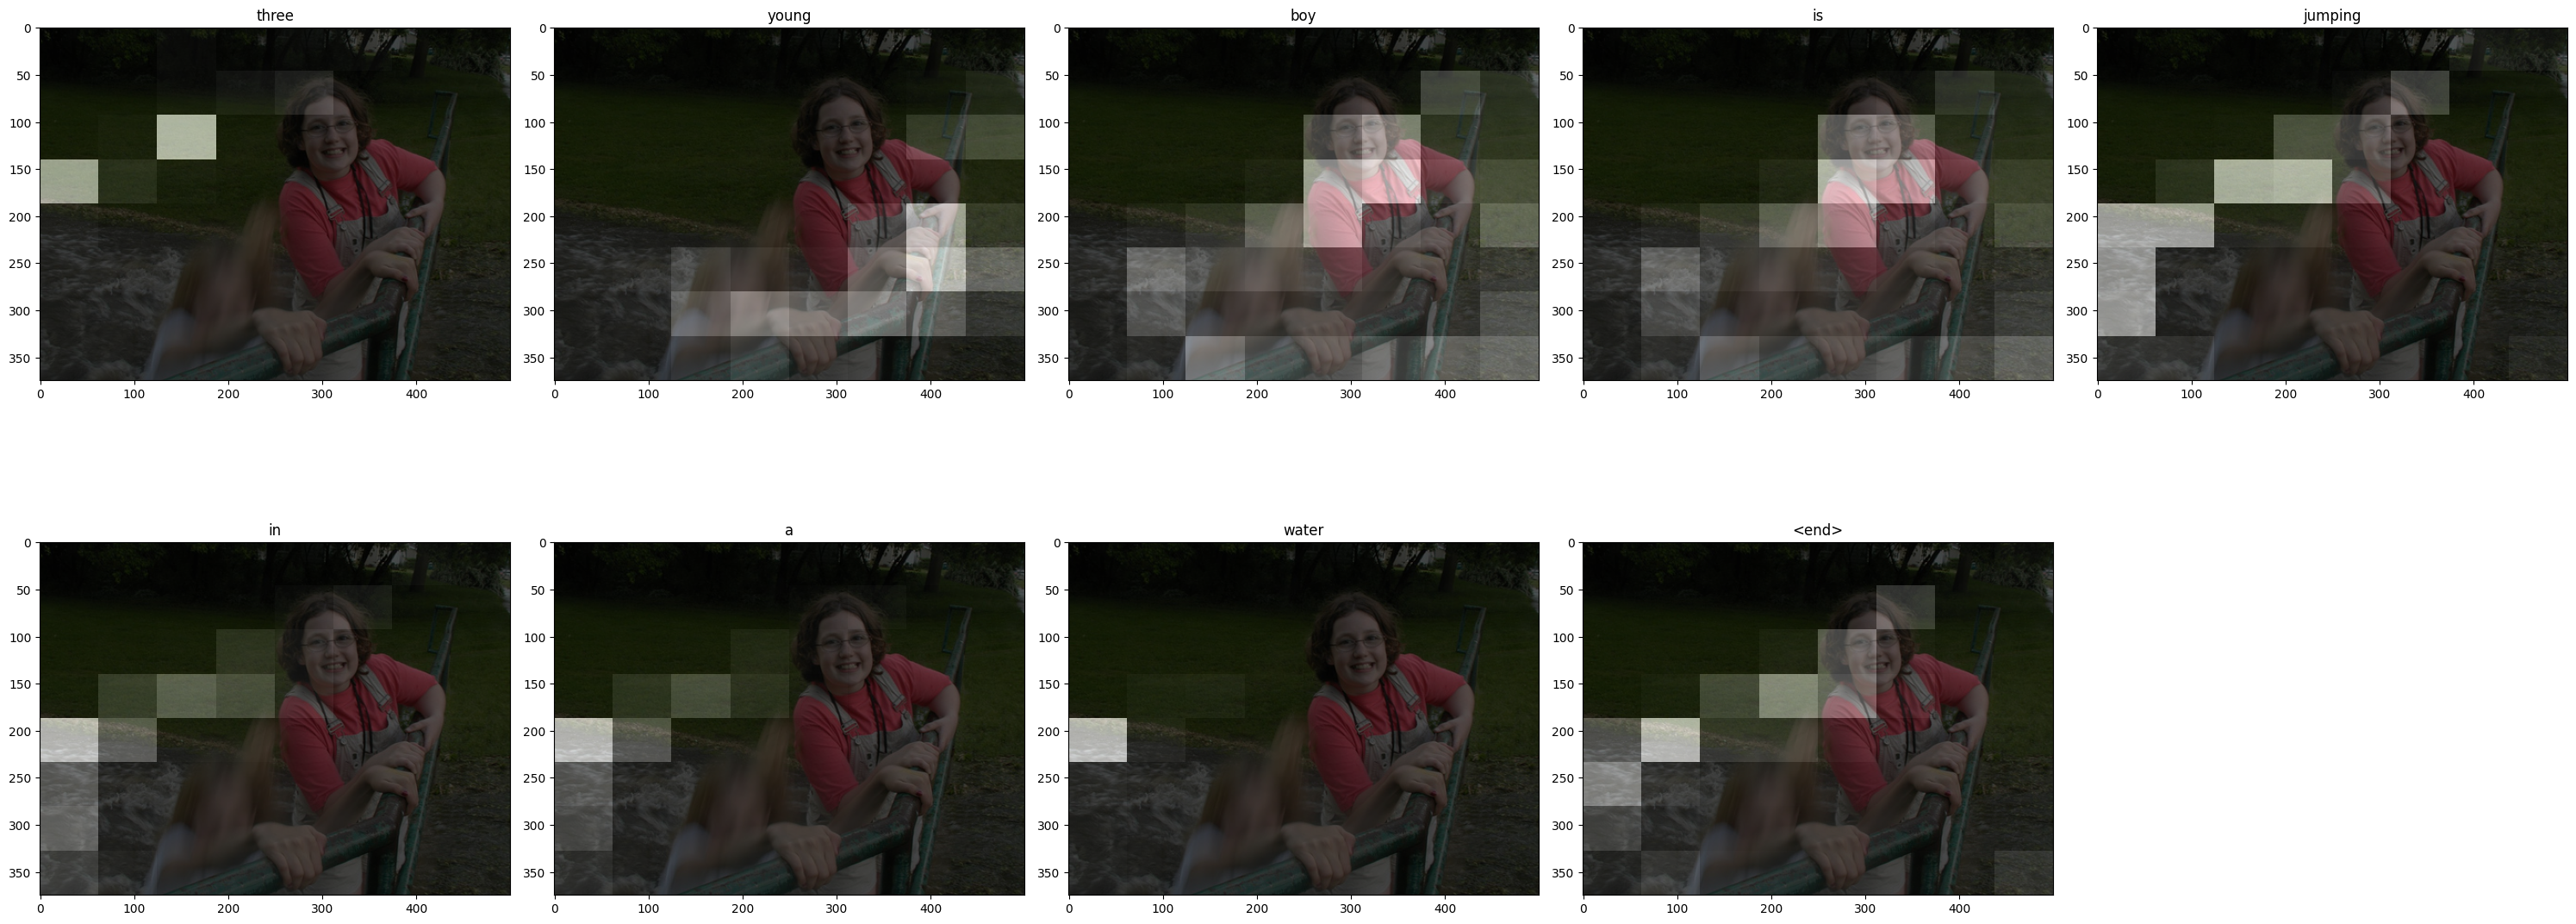

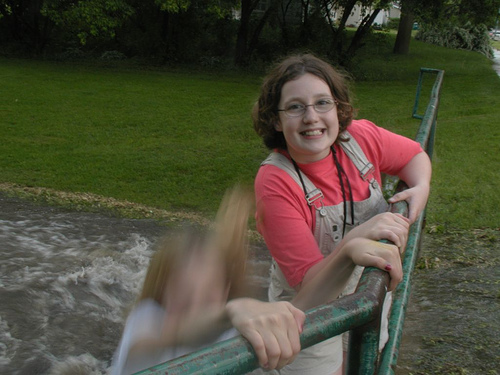

In [70]:
rid = np.random.randint(0,len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result,attention_plot = evaluate(image)
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image,result,attention_plot)

Image.open(img_name_val[rid])